#### <b>GAN 실습</b>

* 논문 제목: Generative Adversarial Networks <b>(NIPS 2014)</b>
* 가장 기본적인 GAN 모델을 학습해보는 실습을 진행합니다.
* 학습 데이터셋: <b>MNIST</b> (1 X 28 X 28)

#### <b>필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

In [1]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

from PIL import Image as img
import matplotlib.pyplot as plt

from IPython.display import Image

In [2]:
# """Utilities.
# """
# import random

# import torch
# from torchvision.transforms.functional import resize, to_tensor, normalize, to_pil_image

# from PIL import Image


# MEAN = (0.485, 0.456, 0.406)
# STD = (0.229, 0.224, 0.225)


# def set_seed(seed=None):
#     """Sets the random seed.
#     """
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False


# def set_device(device=None):
#     """Sets the device.

#     by default sets to gpu.
#     """
#     return torch.device("cpu")


# def prep_img(image: str, size=None, mean=MEAN, std=STD):
#     """Preprocess image.
#     1) load as PIl
#     2) resize
#     3) convert to tensor
#     4) normalize
#     """
#     im = Image.open(image)
#     size = size or im.size[::-1]
#     texture = resize(im, size)
#     texture_tensor = to_tensor(texture).unsqueeze(0)
#     texture_tensor = normalize(texture_tensor, mean=mean, std=std)
#     return texture_tensor


# def denormalize(tensor: torch.Tensor, mean=MEAN, std=STD, inplace: bool = False):
#     """Based on torchvision.transforms.functional.normalize.
#     """
#     tensor = tensor.clone() if not inplace else tensor
#     mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
#     std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
#     tensor.mul_(std).add_(mean)
#     return tensor


# def to_pil(tensor: torch.Tensor):
#     """Converts tensor to PIL Image.

#     Args:
#         tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
#     Returns:
#         PIL Image: converted img.
#     """
#     img = tensor.clone().detach().cpu()
#     img = denormalize(img).clip(0, 1)
#     img = to_pil_image(img)
#     return img


# def to_img(tensor):
#     """To image tensor.
#     """
#     img = tensor.clone().detach().cpu()
#     img = denormalize(img).clip(0, 1)
#     img = img.permute(1, 2, 0)
#     return img


#### <b>생성자(Generator) 및 판별자(Discriminator) 모델 정의</b>

In [3]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 3 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 28, 28)
        return img

In [4]:
# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms



# class Generator(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Convolution, Batch Normalization, ReLU 연산을 합친 함수
#         def CBR2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1):
#             layer = nn.Sequential(
#                 nn.Conv2d(input_channel, output_channel, kernel_size=kernel_size, stride=stride, padding=padding),
#                 nn.BatchNorm2d(num_features=output_channel),
#                 nn.ReLU()
#             )
#             return layer

#         # Down Path ######################
#         # Contracting path
#         # conv 기본적으로 kernel size 3*3 에 stride 1으로 ■■■□□□ □■■■□□ □□■■■□ □□□■■■ =>2칸씩 크기가 줄어든다
#         # 256x256x2 => 256x256x32
#         self.conv1 = nn.Sequential(
#             CBR2d(3, 32, 3, 1),
#             CBR2d(32, 32, 3, 1)
#         )
#         # 256x256x32 => 128x128x32
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         # 128x128x32 => 128x128x64
#         self.conv2 = nn.Sequential(
#             CBR2d(32, 64, 3, 1),
#             CBR2d(64, 64, 3, 1)
#         )
#         # 128x128x64 => 64x64x64
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         # 64x64x64 => 64x64x128
#         self.conv3 = nn.Sequential(
#             CBR2d(64, 128, 3, 1),
#             CBR2d(128, 128, 3, 1)
#         )
#         # 64x64x128 => 32x32x128
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#         # 32x32x128 => 32x32x256
#         # Contracting path 마지막에 Dropout 적용
#         self.conv4 = nn.Sequential(
#             CBR2d(128, 256, 3, 1),
#             CBR2d(256, 256, 3, 1),
#             nn.Dropout(p=0.5)
#         )
#         # 32x32x256 => 16x16x256
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # Contracting path 끝
#         ###################################

#         # Bottlneck 구간 #########512###########
#         # 16x16x256 => 16x16x512
#         self.bottleNeck = nn.Sequential(
#             CBR2d(256, 512, 3, 1),
#             CBR2d(521, 521, 3, 1),
#         )
#         # Bottlneck 구간 끝
#         ###################################

#         # Up Path #########################
#         # Expanding path
#         # channel 수를 감소 시키며 Up-Convolution
#         # 16x16x512 => 32x32x256
#         self.upconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)

#         # Up-Convolution 이후 channel = 256
#         # Contracting path 중 같은 단계의 Feature map을 가져와 Up-Convolution 결과의 Feature map과 Concat 연산
#         # => channel = 512 가 됩니다.
#         # forward 부분을 참고해주세요
#         # 32x32x512 => 32x32x256
#         self.ex_conv1 = nn.Sequential(
#             CBR2d(512, 256, 3, 1),
#             CBR2d(256, 256, 3, 1)
#         )

#         # 32x32x256 => 64x64x128
#         self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

#         # 64x64x256 => 64x64x128
#         self.ex_conv2 = nn.Sequential(
#             CBR2d(256, 128, 3, 1),
#             CBR2d(128, 128, 3, 1)
#         )

#         # 64x64x128 => 128x128x64
#         self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

#         # 128x128x128 => 128x128x64
#         self.ex_conv3 = nn.Sequential(
#             CBR2d(128, 64, 3, 1),
#             CBR2d(64, 64, 3, 1)
#         )

#         # 128x128x64 => 256x256x32
#         self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

#         # 256x256x64 => 256x256x32
#         self.ex_conv4 = nn.Sequential(
#             CBR2d(64, 32, 3, 1),
#             CBR2d(32, 32, 3, 1),

#         )

#         # 논문 구조상 output = 2 channel
#         # train 데이터에서 세포 / 배경을 검출하는것이 목표여서 class_num = 1로 지정
#         # 256x256x32 => 256x256x1
#         self.fc = nn.Conv2d(32, 3, kernel_size=1, stride=1)


#     def forward(self, x):
#         # Contracting path
#         # 572x572x1 => 568x568x64
#         layer1 = self.conv1(x)

#         # Max Pooling
#         # 568x568x64 => 284x284x64
#         out = self.pool1(layer1)

#         # 284x284x64 => 280x280x128
#         layer2 = self.conv2(out)

#         # Max Pooling
#         # 280x280x128 => 140x140x128
#         out = self.pool2(layer2)

#         # 140x140x128 => 136x136x256
#         layer3 = self.conv3(out)

#         # Max Pooling
#         # 136x136x256 => 68x68x256
#         out = self.pool3(layer3)

#         # 68x68x256 => 64x64x512
#         layer4 = self.conv4(out)

#         # Max Pooling
#         # 64x64x512 => 32x32x512
#         out = self.pool4(layer4)

#         # bottleneck
#         # 32x32x512 => 28x28x1024
#         bottleNeck = self.bottleNeck(out)

#         # Expanding path
#         # 28x28x1024 => 56x56x512
#         upconv1 = self.upconv1(bottleNeck)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 56x56x512 => 56x56x1024
#         cat1 = torch.cat((transforms.CenterCrop((upconv1.shape[2], upconv1.shape[3]))(layer4), upconv1), dim=1)
#         # 레이어 4를 중간 기준으로 upconv1 의 h(upconv1.shape[2]),w(upconv1.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 56x56x1024 => 52x52x512
#         ex_layer1 = self.ex_conv1(cat1)

#         # 52x52x512 => 104x104x256
#         upconv2 = self.upconv2(ex_layer1)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 104x104x256 => 104x104x512
#         cat2 = torch.cat((transforms.CenterCrop((upconv2.shape[2], upconv2.shape[3]))(layer3), upconv2), dim=1)
#         # 레이어 3를 중간 기준으로 upconv2 의 h(upconv2.shape[2]),w(upconv2.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 104x104x512 => 100x100x256
#         ex_layer2 = self.ex_conv2(cat2)

#         # 100x100x256 => 200x200x128
#         upconv3 = self.upconv3(ex_layer2)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 200x200x128 => 200x200x256
#         cat3 = torch.cat((transforms.CenterCrop((upconv3.shape[2], upconv3.shape[3]))(layer2), upconv3), dim=1)
#         # 레이어 2를 중간 기준으로 upconv3 의 h(upconv3.shape[2]),w(upconv3.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 200x200x256 => 196x196x128
#         ex_layer3 = self.ex_conv3(cat3)

#         # 196x196x128=> 392x392x64
#         upconv4 = self.upconv4(ex_layer3)

#         # Contracting path 중 같은 단계의 Feature map을 가져와 합침
#         # Up-Convolution 결과의 Feature map size 만큼 CenterCrop 하여 Concat 연산
#         # 392x392x64 => 392x392x128
#         cat4 = torch.cat((transforms.CenterCrop((upconv4.shape[2], upconv4.shape[3]))(layer1), upconv4), dim=1)
#         # 레이어 1를 중간 기준으로 upconv4 의 h(upconv4.shape[2]),w(upconv4.shape[3]) 만큼 잘라서 □■ 나란히 연결

#         # 392x392x128 => 388x388x64
#         out = self.ex_conv4(cat4)

#         # 388x388x64 => 388x388x1
#         out = self.fc(out)
        
#         out2 = nn.Tanh(out)
#         return out2

In [5]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(3 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

#### <b>학습 데이터셋 불러오기</b>

* 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [6]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
train_dataset = datasets.ImageFolder(root="data", transform=transforms)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)


FileNotFoundError: Found no valid file for the classes MNIST. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

#### <b>모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [ ]:
import time

n_epochs = 50 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

            # # Show image
            # plt.imshow(to_pil(generated_imgs.squeeze(0)))
            # plt.show()

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

TypeError: cannot pickle 'module' object

* 생성된 이미지 예시를 출력합니다.

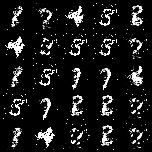

In [ ]:
from IPython.display import Image

Image('92000.png')